In [1]:
import sys 
sys.path.append('/pl/active/banich/studies/Relevantstudies/abcd/env/lib/python3.7/site-packages')
sys.path.append('/pl/active/banich/studies/Clearvale/jake_scripts/Amy_flywheel_scripts/')

import numpy as np
import pandas as pd
import os

In [2]:
import os

def find_subjects_with_both_rest_files(subjects_dir):
    # List to store subjects with both rest1 and rest2 files
    subjects_with_both_rest_files = []

    # Get a list of all subjects in the directory
    subject_folders = [f for f in os.listdir(subjects_dir) if os.path.isdir(os.path.join(subjects_dir, f))]

    # Loop over each subject folder
    for subject in subject_folders:
        subject_folder = os.path.join(subjects_dir, subject)
        rest1_file = os.path.join(subject_folder, 'restrun1.nii.gz')
        rest2_file = os.path.join(subject_folder, 'restrun2.nii.gz')

        # Check if both rest1 and rest2 files exist
        if os.path.exists(rest1_file) and os.path.exists(rest2_file):
            try:
                # Convert subject to integer and append to the list
                subjects_with_both_rest_files.append(int(subject))
            except ValueError:
                # Skip subjects that cannot be converted to integer
                print(f"Skipping subject {subject} (cannot be converted to integer)")

    return subjects_with_both_rest_files

# Define the subjects directory
subjects_dir = '/pl/active/banich/studies/wmem/fmri/subjects/rest_results'

# Find subjects with both rest1 and rest2 files
subjects = find_subjects_with_both_rest_files(subjects_dir)

In [3]:
z_data = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/analysis/ClearMem_Z_Average.csv')
z_data = z_data[['SubID', 'z_ave', 'PSWQ_total', 'WBSI_total', 'RRS_total', 'RRS_depression', 'RRS_brooding', 'RRS_reflection']]
z_data = z_data.dropna()

from scipy.stats import zscore
z_data['br_z_ave'] = z_data['z_ave']
z_data.drop('z_ave', axis=1, inplace=True)
z_data['b_z_ave'] = (zscore(z_data['PSWQ_total']) + zscore(z_data['WBSI_total']) + zscore(z_data['RRS_brooding']))/3
z_data['thought_problems'] = (zscore(z_data['PSWQ_total']) + zscore(z_data['WBSI_total']) + zscore(z_data['RRS_brooding']) + zscore(z_data['RRS_reflection']) + zscore(z_data['RRS_depression']))/5

z_data = z_data[['SubID', 'thought_problems', 'b_z_ave']]

In [6]:
z_data = z_data.query('SubID in @subjects')

In [7]:
eccentricity = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/dispersion_data/derosa_rest_eccentricity.csv')

across_network_disp = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/dispersion_data/derosa_rest_across_network_dispersion.csv')

modularity = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/dispersion_data/derosa_rest_network_modularity.csv')
op_modularity = modularity[['SubID', 'rest_mod']]
network_modularity = modularity[['SubID', 'vn_rest_mod', 'smn_rest_mod', 'fpcn_rest_mod', 'dmn_rest_mod']]

eigcent = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/dispersion_data/derosa_rest_network_eigcent.csv')

within_network_disp = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/dispersion_data/derosa_rest_within_network_dispersion.csv')

grad_ranges = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/dispersion_data/derosa_rest_gradient_range.csv')

In [60]:
rsa_rest_ecc = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/dispersion_data/derosa_rest_rsa_eccentricity.csv')
rsa_rest_disp = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/dispersion_data/derosa_rest_rsa_within_network_dispersion.csv')
rsa_rest_mets = pd.merge(rsa_rest_ecc, rsa_rest_disp, on='SubID')

In [8]:
grad_subs = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/analysis/all_metrics_z.csv').SubID.to_list()

In [9]:
all_mets = pd.merge(eccentricity, across_network_disp, on='SubID')
all_mets = pd.merge(all_mets, op_modularity, on='SubID')
all_mets = pd.merge(all_mets, network_modularity, on='SubID')
all_mets = pd.merge(all_mets, within_network_disp, on='SubID')
all_mets = pd.merge(all_mets, grad_ranges, on='SubID')

all_mets['SubID'] = all_mets['SubID'].astype(int)
#all_mets = all_mets.query('SubID in @grad_subs')

In [10]:
all_mets.shape

(58, 23)

In [40]:
import sys 

sys.path.append('/pl/active/banich/studies/Relevantstudies/abcd/env/lib/python3.7/site-packages')
sys.path.append('/pl/active/banich/studies/Clearvale/jake_scripts/Amy_flywheel_scripts/')

import sys 
import os
import glob
import numpy as np
import scipy.io
import pandas as pd

def run_regression(data, target, y_var, interaction=None):
    import pandas as pd
    import statsmodels.api as sm
    import statsmodels.formula.api as smf
    
    if interaction is not None:
        # Creating the formula with interaction terms if specified
        formula = f'{target[0]} ~ {y_var} * {interaction}'
    else:
        formula = f'{target[0]} ~ {y_var}'

    # Fit the regression model using the formula
    model = smf.ols(formula=formula, data=data).fit()

    # Print the full regression output
    summary = model.summary()

    var = pd.DataFrame(summary.tables[0].data).iloc[0, 1]

    table1 = pd.DataFrame(summary.tables[0].data).iloc[:4, 3:].T.assign(var=var)
    table1.columns = ['r2', 'adjr2', 'fstat', 'pval', 'var']
    table1 = table1[['var', 'r2', 'adjr2', 'fstat', 'pval']]

    table2_cols = pd.DataFrame(summary.tables[1].data).loc[0].to_list() + ['var']
    table2_cols[0] = 'parameter'
    table2 = pd.DataFrame(summary.tables[1].data).iloc[1:].assign(var=var)
    table2.columns = table2_cols
    table2 = table2[['var', 'parameter', 'coef', 'std err', 't', 'P>|t|']]

    df = pd.merge(table1, table2, how='outer', left_on='var', right_on='parameter')

    # Combine 'var_x' and 'var_y' into a new column 'var'
    df['var'] = df['var_x'].fillna(df['var_y'])

    # Drop the original 'var_x' and 'var_y' columns
    df.drop(columns=['var_x', 'var_y'], inplace=True)

    # Reorder columns to place 'var' at the front
    cols = ['var'] + [col for col in df.columns if col != 'var']
    df = df[cols]
    df = df.assign(formula=formula)

    return df


def regression_function(data, variable_list, interaction):
    import pandas as pd

    targets = [['thought_problems']]

    regression_results = []
    for target in targets:
        for variable in variable_list:
            regression_results.append(run_regression(data, target, variable, interaction))

    output_regressions = pd.concat(regression_results)

    # List of columns to convert
    columns_to_convert = ['r2', 'adjr2', 'fstat', 'pval', 'coef', 'std err', 't', 'P>|t|']

    # Convert each specified column to numeric, handling non-numeric values by converting them to NaN
    for column in columns_to_convert:
        output_regressions[column] = pd.to_numeric(output_regressions[column], errors='coerce')

    return output_regressions#[['var', 'r2', 'adjr2', 'fstat', 'pval', 'formula']]

In [56]:
predictors = all_mets.filter(regex='ecc|dispersion|thought').columns.to_list()
all_mets_z = pd.merge(z_data, all_mets, on='SubID').filter(regex='SubID|ecc|dispersion|thought')
all_mets_z.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/rest_all_metrics_z.csv', index=False)

In [68]:
all_rsa_mets_z = pd.merge(z_data, rsa_rest_mets, on='SubID').filter(regex='SubID|ecc|dispersion|thought')
all_rsa_mets_z.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/rest_rsa_all_metrics_z.csv', index=False)

In [57]:
def run_regs(data, test_cols, method):
    
    regression_output = regression_function(data, test_cols, interaction=None)
    regression_sig_vars = regression_output.query('pval < .05').formula.to_list()
    regression_full_sig_output = regression_output#.query('formula in @regression_sig_vars')
    #regression_full_sig_output.to_csv(f'/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/grapth_theory/regression_outputs/all_op_sig_outputs_{method}.csv', index=False)
    
    return regression_full_sig_output

out = run_regs(all_mets_z, predictors, 'cosine')#.formula.unique()

In [15]:
import re
import pandas as pd

# Assuming across_network_disp is already defined as a DataFrame
# List of column names
columns = across_network_disp.columns

def extract_combos(columns):
    pattern = re.compile(r'_(vn|smn|fpcn|dmn)_(vn|smn|fpcn|dmn)_disp')
    combos = set()
    
    for column in columns:
        match = pattern.search(column)
        if match:
            combos.add(match.group(0)[1:-5])  # Exclude leading underscore and trailing '_disp'
    
    return list(combos)

combos = extract_combos(columns)

def across_op_network_means(data, combo):
    sub = data[['SubID']]
    mean = pd.DataFrame(data.filter(regex=combo).T.mean())
    
    output = pd.concat([sub, mean], axis=1)
    
    output.columns = ['SubID', f'{combo}_disp']
        
    return output

# Initialize an empty DataFrame to store the combined results
combined_df = pd.DataFrame()

# Loop through each combo and combine the results
for combo in combos:
    result = across_op_network_means(across_network_disp, combo)
    if combined_df.empty:
        combined_df = result
    else:
        combined_df = pd.merge(combined_df, result, on='SubID')

across_network_disp_means = combined_df

In [16]:
def network_means(data, net, metric):
    
    sub = data[['SubID']]
    mean = data.filter(regex=f'{net}').T.mean()

    output = pd.concat([sub, mean], axis=1)
    
    output.columns = ['SubID', f'{net}_{metric}']
    
    return output

def drop_duplicate_columns(df):
    # Transpose the DataFrame to easily check for duplicate columns
    df_transposed = df.T
    
    # Remove duplicate columns
    df_transposed = df_transposed.drop_duplicates()
    
    # Transpose back to the original DataFrame structure
    df_cleaned = df_transposed.T
    
    return df_cleaned



In [17]:
def get_net_means(data, metric):
    
    network_outputs = []
    for i in ['vn', 'smn', 'fpcn', 'dmn']:
        network_outputs.append(network_means(data, i, metric))

    output = drop_duplicate_columns(pd.concat(network_outputs, axis=1))

    output['SubID'] = output['SubID'].astype(int)
    
    return output

In [18]:
def get_op_means(data, metric):
    
    op_outputs = []
    for i in ['rest']:
        op_outputs.append(network_means(data, i, metric))

    output = drop_duplicate_columns(pd.concat(op_outputs, axis=1))

    output['SubID'] = output['SubID'].astype(int)
    
    return output

In [19]:
network_modularity_means = get_net_means(network_modularity, 'mod')

within_network_disp_means = get_net_means(within_network_disp, 'disp')

eigcent_means = get_net_means(eigcent, 'eigcent')

eccentricity_means = get_net_means(eccentricity, 'ecc')

all_network_means = pd.merge(across_network_disp_means, within_network_disp_means, on='SubID')
all_network_means = pd.merge(all_network_means, eccentricity_means, on='SubID')
all_network_means = pd.merge(all_network_means, eigcent_means, on='SubID')
all_network_means = pd.merge(all_network_means, network_modularity_means , on='SubID')

In [20]:
op_network_across_disp_means = get_op_means(across_network_disp, 'across_disp')

op_network_disp_means = get_op_means(within_network_disp, 'within_disp')

op_eigcent_means = get_op_means(eigcent, 'eigcent')

op_eccentricity_means = get_op_means(eccentricity, 'ecc')

all_op_means = pd.merge(op_network_disp_means, op_network_across_disp_means, on='SubID')
all_op_means = pd.merge(all_op_means, op_eccentricity_means, on='SubID')
all_op_means = pd.merge(all_op_means, op_eigcent_means, on='SubID')
all_op_means = pd.merge(all_op_means, op_modularity, on='SubID')

In [21]:

all_metrics = pd.merge(all_network_means, all_op_means, on='SubID')
all_metrics = pd.merge(all_metrics, grad_ranges, on='SubID')

In [22]:
all_metrics_z = pd.merge(all_metrics, z_data, on='SubID')

In [23]:
all_metrics_z.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/rest_all_metrics_z.csv', index=False)

all_metrics_z_pull = all_metrics_z[['SubID', 'vn_ecc','fpcn_ecc', 'fpcn_disp', 'dmn_ecc', 'dmn_disp']]
all_metrics_z_pull.columns = ['SubID', 'vn_ecc_rest', 'fpcn_ecc_rest', 'fpcn_disp_rest', 'dmn_ecc_rest', 'dmn_disp_rest']

all_metrics_z_pull.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/rest_all_metrics_z.csv', index=False)

In [24]:
all_metrics_z['SubID'] = all_metrics_z['SubID'].astype(int)
#all_metrics_z = all_metrics_z.query('SubID in @pull_list').reset_index(drop=True)

In [26]:
all_metrics_z.columns

Index(['SubID', 'vn_dmn_disp', 'smn_fpcn_disp', 'fpcn_dmn_disp', 'vn_smn_disp',
       'smn_dmn_disp', 'vn_fpcn_disp', 'vn_disp', 'smn_disp', 'fpcn_disp',
       'dmn_disp', 'vn_ecc', 'smn_ecc', 'fpcn_ecc', 'dmn_ecc', 'vn_eigcent',
       'smn_eigcent', 'fpcn_eigcent', 'dmn_eigcent', 'vn_mod', 'smn_mod',
       'fpcn_mod', 'dmn_mod', 'rest_within_disp', 'rest_across_disp',
       'rest_ecc', 'rest_eigcent', 'rest_mod', 'rest_g1', 'rest_g2', 'rest_g3',
       'thought_problems', 'b_z_ave'],
      dtype='object')

In [155]:
def run_regression(data, target, y_vars, interaction=None):
    import pandas as pd
    import statsmodels.api as sm
    import statsmodels.formula.api as smf
    
    if interaction is not None:
        # Creating the formula with interaction terms if there are multiple y_vars
        if len(y_vars) > 1:
            joined_vars = ' * '.join(y_vars)
        else:
            joined_vars = y_vars[0]
        
        new_y_vars = [joined_vars]
        formula = f'{target[0]} ~ {joined_vars}'

    else:
        joined_vars = ' + '.join(y_vars)
        new_y_vars = [joined_vars]
        formula = f'{target[0]} ~ {joined_vars}'

    # Fit the regression model using the formula
    model = smf.ols(formula=formula, data=data).fit()

    # Print the full regression output
    summary = model.summary()

    var = pd.DataFrame(summary.tables[0].data).iloc[0, 1]

    table1 = pd.DataFrame(summary.tables[0].data).iloc[:4, 3:].T.assign(var=var)
    table1.columns = ['r2', 'adjr2', 'fstat', 'pval', 'var']
    table1 = table1[['var', 'r2', 'adjr2', 'fstat', 'pval']]

    table2_cols = pd.DataFrame(summary.tables[1].data).loc[0].to_list() + ['var']
    table2_cols[0] = 'parameter'
    table2 = pd.DataFrame(summary.tables[1].data).iloc[1:].assign(var=var)
    table2.columns = table2_cols
    table2 = table2[['var', 'parameter', 'coef', 'std err', 't', 'P>|t|']]

    df = pd.merge(table1, table2, how='outer', left_on='var', right_on='parameter')

    # Combine 'var_x' and 'var_y' into a new column 'var'
    df['var'] = df['var_x'].fillna(df['var_y'])

    # Drop the original 'var_x' and 'var_y' columns
    df.drop(columns=['var_x', 'var_y'], inplace=True)

    # Reorder columns to place 'var' at the front
    cols = ['var'] + [col for col in df.columns if col != 'var']
    df = df[cols]
    df = df.assign(formula=formula)

    return df


def regression_function(data, variable_list, interaction):
    import itertools
    import pandas as pd

    # Given list
    variables = variable_list
    targets = [['thought_problems']]

    # Create a list to hold all combinations
    all_combinations = []

    # Generate combinations for each length from 1 to min(length of the list, 6)
    for r in range(1, min(len(variables), 5) + 1):
        combinations = list(itertools.combinations(variables, r))
        all_combinations.extend(combinations)

    # Convert each tuple to a list
    list_combinations = [list(item) for item in all_combinations]

    regression_combinations = []
    for i in targets:
        for j in list_combinations:
            regression_combinations.append(run_regression(data, i, j, interaction))

    output_regressions = pd.concat(regression_combinations)

    # List of columns to convert
    columns_to_convert = ['r2', 'adjr2', 'fstat', 'pval', 'coef', 'std err', 't', 'P>|t|']

    # Convert each specified column to numeric, handling non-numeric values by converting them to NaN
    for column in columns_to_convert:
        output_regressions[column] = pd.to_numeric(output_regressions[column], errors='coerce')

    return output_regressions[['var', 'r2', 'adjr2', 'fstat', 'pval','formula']]


In [156]:
test_cols = ['vn_smn_disp', 'smn_fpcn_disp', 'vn_fpcn_disp', 'fpcn_dmn_disp', 'vn_dmn_disp', 'smn_dmn_disp']

regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05')

,var,r2,adjr2,fstat,pval,formula


In [157]:
test_cols = ['rest_across_disp']

regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05')

,var,r2,adjr2,fstat,pval,formula


In [158]:
test_cols = ['vn_disp', 'smn_disp', 'fpcn_disp', 'dmn_disp']

regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05')

,var,r2,adjr2,fstat,pval,formula


In [159]:
test_cols = [ 'rest_within_disp']

regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05')

,var,r2,adjr2,fstat,pval,formula


In [160]:
test_cols = ['vn_ecc', 'smn_ecc', 'fpcn_ecc', 'dmn_ecc']

regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05').sort_values('fstat', ascending=False)

,var,r2,adjr2,fstat,pval,formula
0,thought_problems,0.171,0.149,7.634,0.00887,thought_problems ~ fpcn_ecc
0,thought_problems,0.171,0.149,7.634,0.00887,thought_problems ~ vn_ecc + fpcn_ecc
0,thought_problems,0.185,0.140,4.099,0.02490,thought_problems ~ smn_ecc + fpcn_ecc
0,thought_problems,0.185,0.140,4.099,0.02490,thought_problems ~ vn_ecc + smn_ecc + fpcn_ecc
0,thought_problems,0.171,0.125,3.725,0.03390,thought_problems ~ fpcn_ecc + dmn_ecc
0,thought_problems,0.171,0.125,3.725,0.03390,thought_problems ~ vn_ecc + fpcn_ecc + dmn_ecc


In [161]:
test_cols = ['vn_ecc', 'smn_ecc', 'fpcn_ecc', 'dmn_ecc']

regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05').formula.to_list()

['thought_problems ~ fpcn_ecc',
 'thought_problems ~ vn_ecc + fpcn_ecc',
 'thought_problems ~ smn_ecc + fpcn_ecc',
 'thought_problems ~ fpcn_ecc + dmn_ecc',
 'thought_problems ~ vn_ecc + smn_ecc + fpcn_ecc',
 'thought_problems ~ vn_ecc + fpcn_ecc + dmn_ecc']

In [162]:
test_cols = ['rest_ecc']

regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05')

,var,r2,adjr2,fstat,pval,formula


In [78]:
test_cols = ['vn_eigcent', 'smn_eigcent','fpcn_eigcent', 'dmn_eigcent']

regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05')

,var,r2,adjr2,fstat,pval,formula


In [79]:
test_cols = ['rest_eigcent']

regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05')

,var,r2,adjr2,fstat,pval,formula


In [80]:
test_cols = ['rest_mod']

regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05')

,var,r2,adjr2,fstat,pval,formula


In [81]:
test_cols = ['vn_mod', 'smn_mod', 'fpcn_mod', 'dmn_mod']

regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05')

,var,r2,adjr2,fstat,pval,formula


In [82]:
test_cols = ['rest_g1', 'rest_g2', 'rest_g3']

regression_function(all_metrics_z, test_cols, interaction=None).query('pval < .05')

,var,r2,adjr2,fstat,pval,formula


In [ ]:
# Formulas
formulas = [
    'vn_ecc + smn_ecc + fpcn_ecc + dmn_ecc',
    'vn_ecc + smn_ecc',
    'vn_ecc + fpcn_ecc + dmn_ecc',
    'smn_ecc + dmn_ecc',
    'fpcn_ecc + dmn_ecc + smn_ecc',
    'vn_ecc + fpcn_ecc'
]

# Updated reg_formulas list
reg_formulas = [
    ['vn_ecc + smn_ecc + fpcn_ecc + dmn_ecc'],
    ['vn_ecc + smn_ecc'],
    ['vn_ecc + fpcn_ecc + dmn_ecc'],
    ['smn_ecc + dmn_ecc'],
    ['fpcn_ecc + dmn_ecc + smn_ecc'],
    ['vn_ecc + fpcn_ecc']
]

# Updated reg_vars list
reg_vars = [
    ['vn_ecc', 'smn_ecc', 'fpcn_ecc', 'dmn_ecc'],
    ['vn_ecc', 'smn_ecc'],
    ['vn_ecc', 'fpcn_ecc', 'dmn_ecc'],
    ['smn_ecc', 'dmn_ecc'],
    ['fpcn_ecc', 'dmn_ecc', 'smn_ecc'],
    ['vn_ecc', 'fpcn_ecc']
]


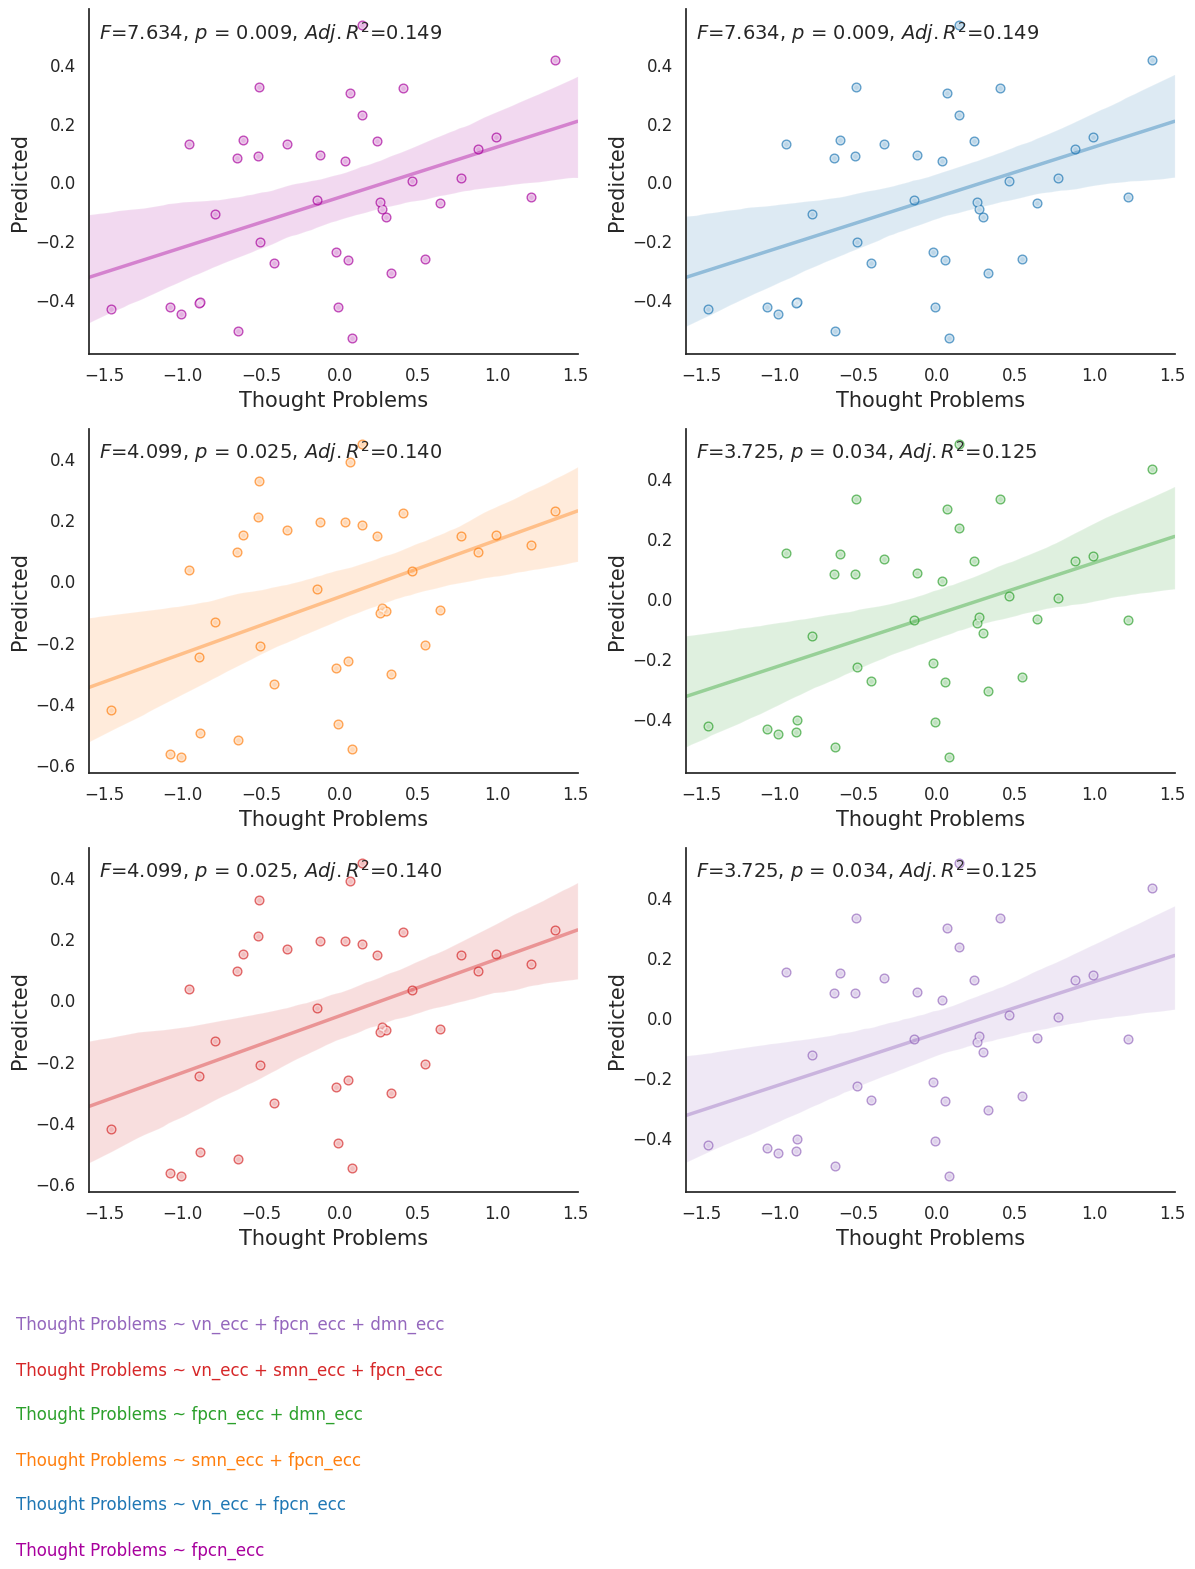

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

def reg_plots(data, x_vars, yvar, color, ax):
    joined_vars = ' + '.join(x_vars)
    formula = f'{yvar[0]} ~ {joined_vars}'

    # Fit the regression model using the formula
    model = smf.ols(formula=formula, data=data).fit()

    # Store the predicted values in the data
    data['Predicted'] = model.predict()

    # Scatter plot with regression line
    sns.set_theme(style="white")

    # Scatter plot with regression line modifications
    sns.regplot(y='Predicted', x=f'{yvar[0]}', data=data, ci=95,
                color=color, scatter_kws={'s': 40, 'alpha': 0.6}, truncate=False, ax=ax,
                line_kws={'linewidth': 2.5, 'alpha': 0.4})

    sns.regplot(y='Predicted', x=f'{yvar[0]}', data=data, fit_reg=False,
                color='white', scatter_kws={'s': 20, 'alpha': .5}, truncate=False, ax=ax)

    # Set axis labels
    ax.set_xlabel('Thought Problems', fontsize=15)
    ax.set_ylabel('Predicted', fontsize=15)

    # Adding subtitle with F-statistic and p-value using text annotation, with 'p' in italic
    p_value_text = f"< .001" if model.f_pvalue < 0.001 else f"= {model.f_pvalue:.3f}"
    subtitle = f"$\it{{F}}$={model.fvalue:.3f}, $\it{{p}}$ {p_value_text}, $\it{{Adj. R}}^2$={model.rsquared_adj:.3f}"
    ax.text(0.02, .97, subtitle, transform=ax.transAxes, fontsize=14, verticalalignment='top')

    ax.tick_params(axis='both', labelsize=12)  # Increase tick label font size

    # Remove top and right borders
    sns.despine()

# Formulas
formulas = [
    'fpcn_ecc',
    'vn_ecc + fpcn_ecc',
    'smn_ecc + fpcn_ecc',
    'fpcn_ecc + dmn_ecc',
    'vn_ecc + smn_ecc + fpcn_ecc',
    'vn_ecc + fpcn_ecc + dmn_ecc'
]

# Updated reg_formulas list
reg_formulas = [
    ['fpcn_ecc'],
    ['vn_ecc + fpcn_ecc'],
    ['smn_ecc + fpcn_ecc'],
    ['fpcn_ecc + dmn_ecc'],
    ['vn_ecc + smn_ecc + fpcn_ecc'],
    ['vn_ecc + fpcn_ecc + dmn_ecc']
]

# Updated reg_vars list
reg_vars = [
    ['fpcn_ecc'],
    ['vn_ecc', 'fpcn_ecc'],
    ['smn_ecc', 'fpcn_ecc'],
    ['fpcn_ecc', 'dmn_ecc'],
    ['vn_ecc', 'smn_ecc', 'fpcn_ecc'],
    ['vn_ecc', 'fpcn_ecc', 'dmn_ecc']
]



colors = ['#a8009d', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

fig, axes = plt.subplots(3, 2, figsize=(12, 15))

# Add a single title at the top center
#fig.suptitle('Top Gradient Metrics Predicting Thought Problems', fontsize=18, fontweight='bold')

for i, ax in enumerate(axes.flatten()):
    if i < len(reg_formulas):
        reg_plots(
            all_metrics_z_yeo, 
            reg_vars[i], 
            ['thought_problems'], 
            colors[i], 
            ax
        )

# Add the formula titles at the bottom left of the figure
for i, formula in enumerate(reg_formulas):
    fig.text(0.01, -0.095 + (i * 0.03), f'Thought Problems ~ {formula[0]}', ha='left', fontsize=12, color=colors[i], va='bottom')

plt.tight_layout(rect=[-.01, 0.1, 1, 0.95])  # Adjust the layout to make space for the main title and formula text
plt.show()
